# ML Modeling

## Libraries

In [1]:
# main libraries
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import plot_confusion_matrix

# ML classifier models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

# resampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter

# model selection (CV)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy.stats import randint

## Machine Learning

### Separating the DF into X and Y

In [2]:
bank = pd.read_csv("../data/bank_processed_data.csv", index_col=0)
bank.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,...,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Education_Level_encoded,Income_Category_encoded,Card_Category_encoded,x0_Married,x0_Single,x0_Unknown,x1_Existing Customer,x2_M
0,45,3,39,5,1,3,12691.0,777,1.335,1144,...,1.625,0.061,2.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0
1,49,5,44,6,1,2,8256.0,864,1.541,1291,...,3.714,0.105,4.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,51,3,36,4,1,0,3418.0,0,2.594,1887,...,2.333,0.000,4.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0
3,40,4,34,3,4,1,3313.0,2517,1.405,1171,...,2.333,0.760,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,40,3,21,5,1,0,4716.0,0,2.175,816,...,2.500,0.000,1.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0


In [3]:
# separating X and y
X = bank.drop(columns="x1_Existing Customer")
y = bank["x1_Existing Customer"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 42)

In [4]:
# Scaling the data

scaler = StandardScaler() # initialize the scaler

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Choosing the Models

The column that I want to identify is **x1_Existing Customer**, being **1** if the customer is still a customer, and **0** otherwise. In this case, as it's a True/False decission, the models that fit better for this type of Supervised ML are the Classifiers.

I will start checking the different models, without parameter tuning, for identify which are the models that perform better.

In [424]:
# Initializing the models

neigh = KNeighborsClassifier()
tree = DecisionTreeClassifier()
gradient = GradientBoostingClassifier()
RF = RandomForestClassifier()
adaboost = AdaBoostClassifier()
extra_tree = ExtraTreesClassifier()
support_vector = SVC()


models = [neigh, tree, RF, adaboost, gradient, extra_tree, support_vector]
model_names = ["KNeighbors", "DecisionTree", "RandomForest", "AdaBoost", 
               "GradientBoost", "ExtraTress", "SVC"]

The data per each category is not balanced, as customers represent 83.8% of the sample, the accuracy here is not relevant. 

In this scenario, I will focus more on `recall`, to ensure that the model classifies correctly the labels, and the precision. Mention that, the main focus will be on the label **0.0, as it is the customers that already churned the bank, and we want to focus on that part** to ensure that our model is able to predict possible future cases and act before churn happens.

Last, but not least, `macro avg` will also be taken into consideration, as we want to ensure that **0.0** are classified correctly, but we want that the amount of **1.0** are good too. I would have to find the perfect balance between those metrics.

*NOTES*

The `precision` is the ratio TP / (TP + FP) where TP is the number of true positives and FP the number of false positives. The precision is intuitively **the ability of the classifier not to label as positive a sample that is negative**.

The `recall` is the ratio TP / (TP + FN) where TP is the number of true positives and FN the number of false negatives. The recall is intuitively **the ability of the classifier to find all the positive samples**. Note that in binary classification, recall of the positive class is also known as `sensitivity`; recall of the negative class is `specificity`.

The most important for this work is to increase the **sensitivity** (to detect all churn cases). Even though the other parameters are very important also.

#### Finding the best classification model

In [5]:
def top3_classifier_model(models):
    """
    Input: Models to test
    Output: DF top 3 models
    """
    # first batch of empty lists    
    time_to_train = []
    accuracy = []
    macro_precision = []
    macro_recall = []
    macro_F1 = []
    report_dict = []

    for model in models:    
        start = time.time()
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # metrics
        accuracy_ = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average="macro")
        precision = precision_score(y_test, y_pred, average="macro")
        f1 = f1_score(y_test, y_pred, average="macro")
        clasf_report_dict = classification_report(y_test, y_pred, output_dict=True)

        # appending to empty lists
        time_to_train.append((time.time() - start))
        accuracy.append(round(accuracy_,4))
        macro_precision.append(round(precision,4))
        macro_recall.append(round(recall,4))
        macro_F1.append(round(f1,4))
        report_dict.append(clasf_report_dict)
    
    # second batch
    precision_0 = []
    recall_0 = []
    f1_0 = []
    precision_1 = []
    recall_1 = []
    f1_1 = []

    for report in report_dict:
        # Info of churn label
        precision_0.append(round(report["0.0"]["precision"],4))
        recall_0.append(round(report["0.0"]["recall"],4))
        f1_0.append(round(report["0.0"]["f1-score"],4))

        # Info of current customers
        precision_1.append(round(report["1.0"]["precision"],4))
        recall_1.append(round(report["1.0"]["recall"],4))
        f1_1.append(round(report["1.0"]["f1-score"],4))
        
    # creating DF
    best_models_DF = pd.DataFrame({"model":model_names,
                                   "training_time":time_to_train,
                                   "accuracy":accuracy,
                                   "precision_macro":macro_precision,
                                   "recall_macro":macro_recall,
                                   "f1_macro":macro_F1,
                                   "precision_0":precision_0,
                                   "recall_0":recall_0,
                                   "f1_0":f1_0,
                                   "precision_1":precision_1,
                                   "recall_1":recall_1,
                                   "f1_1":f1_1
                                  })
    
    # getting top 3 models
    top3 = best_models_DF.sort_values(by=["f1_macro"], ascending=False).reset_index(drop=True).iloc[:3]
    
    return top3

In [426]:
top3_classifier_model(models)

,model,training_time,accuracy,precision_macro,recall_macro,f1_macro,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1
0,GradientBoost,1.494767,0.9650,0.9478,0.9194,0.9328,0.9233,0.8523,0.8864,0.9722,0.9865,0.9793
1,RandomForest,0.832721,0.9625,0.9457,0.9117,0.9276,0.9220,0.8369,0.8774,0.9694,0.9865,0.9779
2,AdaBoost,0.367705,0.9605,0.9332,0.9180,0.9254,0.8939,0.8554,0.8742,0.9726,0.9806,0.9766


The three models that does the best selection for the churned customers and also for the actual customers are **GradientBoost**, **AdaBoost** and **RandomForest**.

Now that we have in mind which models work best, let's start tuning them for improve their results

### Tuning Models

#### GradientBoost

In [63]:
# start_time = time.time()

# gradient_params = {"loss":["deviance", "exponential"],
#                   "criterion":["friedman_mse", "mse", "mae"],
#                   "max_features":["auto", "sqrt", "log2"],
#                   "n_estimators":randint(low=50, high=300),
#                   "max_depth":randint(low=2, high=8),
#                   "max_leaf_nodes":randint(low=5, high=15)
#                   }

# scorers = {"precision_score": make_scorer(precision_score, average="macro"),
#            "recall_score": make_scorer(recall_score, average="macro"),
#            "f1_score": make_scorer(f1_score, average="macro")
#           }

# gradient_search = RandomizedSearchCV(gradient,
#                                      gradient_params,
#                                      n_iter=10,
#                                      n_jobs=-1,
#                                      cv=StratifiedKFold(),
#                                      scoring=scorers,
#                                      refit=False,
#                                      random_state=42
#                                     )

# gradient_search.fit(X_train_scaled, y_train)

# print("--- %s seconds ---" % (time.time() - start_time))

After the results obtained, I will create a DF for visualize which are the scores for each scoring. After that, I will pick the parameters that performed better for passing it to GridSearchCV.

In [64]:
# gradient_results = pd.DataFrame(gradient_search.cv_results_)

# gradient_results = gradient_results[["params", "mean_test_precision_score", "rank_test_precision_score",
#                                      "mean_test_recall_score", "rank_test_recall_score",
#                                      "mean_test_f1_score", "rank_test_f1_score"]]

# gradient_results

In [65]:
# gradient_results["params"][4]

When we know which are the best parameters to pass to the model, we will create a function for each one of them and then obtain their respective **y_pred**. The **y_value** obtained will be stored in a variable for, later on, build the `classification_report` and `confusion_matrix`.

The structure will be the same for future models and variations.

In [26]:
def gradient_gridsearch(X_train, y_train):
    """
    Input: X_train and y_train for model training
    Output: Best params
    
    """
    # Inputting the different parameters obtained from the RandomizedSearchCV
    gradient_params = {"loss":["deviance", "exponential"],
                       "criterion":["friedman_mse", "mse"],
                       "max_features":["log2","sqrt"],
                       "n_estimators":[260, 265, 270, 275, 280],
                       "max_depth":[3, 4, 5],
                       "max_leaf_nodes":[10, 12, 14, 16]
                      }

    # Running the best_gradient with GridSearchCV
    best_gradient = GridSearchCV(gradient,
                                 gradient_params,
                                 n_jobs=-1,
                                 cv=StratifiedKFold(),
                                 scoring="f1_macro"
                                )
    
    best_gradient.fit(X_train, y_train)
    
    best = best_gradient.best_estimator_
    
    return best

In [27]:
gradient_gridsearch(X_train_scaled, y_train)

GradientBoostingClassifier(max_depth=5, max_features='sqrt', max_leaf_nodes=16,
                           n_estimators=275)

In [7]:
def gradient_trainer(X_train, X_test, y_train, y_test, loss, criterion, max_features, n_estimators, max_depth, max_leaf_nodes):
    """
    Input: All the inputs for training the GradientBoostingClassifier with GridSearchCV
    Output: y_pred
    """
    # Creating the best_gradient 
    best_gradient = GradientBoostingClassifier(loss=loss, criterion=criterion,
                                               max_features=max_features, n_estimators=n_estimators,
                                               max_depth=max_depth, max_leaf_nodes=max_leaf_nodes
                                              )
    
    # Model fit
    best_gradient.fit(X_train, y_train)
    
    # Model train
    y_pred = best_gradient.predict(X_test)
    
    # Getting classification report
    c_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, target_names=['Churn', 'Customer']))
    
    # Getting Kappa score
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return y_pred, c_report, kappa

In [72]:
y_pred_gradient, classification_report_gradient, kappa_gradient = gradient_trainer(X_train_scaled,
                                                                                   X_test_scaled,
                                                                                   y_train,
                                                                                   y_test,
                                                                                   "deviance",
                                                                                   "friedman_mse",
                                                                                   "log2",
                                                                                   265,
                                                                                   5,
                                                                                   14
                                                                                  )

#### AdaBoost

In [13]:
# start_time = time.time()

# adaboost_params = {"algorithm":["SAMME", "SAMME.R"],
#                   "n_estimators":randint(low=10, high=200)
#                   }

# scorers = {"precision_score": make_scorer(precision_score, average="macro"),
#            "recall_score": make_scorer(recall_score, average="macro"),
#            "f1_score": make_scorer(f1_score, average="macro")
#           }

# adaboost_search = RandomizedSearchCV(adaboost,
#                                      adaboost_params,
#                                      n_iter=10,
#                                      n_jobs=-1,
#                                      cv=10,
#                                      scoring=scorers,
#                                      refit=False,
#                                      random_state=42
#                                     )

# adaboost_search.fit(X_train_scaled, y_train)

# print("--- %s seconds ---" % (time.time() - start_time))

In [14]:
# adaboost_results = pd.DataFrame(adaboost_search.cv_results_)

# adaboost_results = adaboost_results[["params", "mean_test_precision_score", "rank_test_precision_score",
#                                      "mean_test_recall_score", "rank_test_recall_score",
#                                      "mean_test_f1_score", "rank_test_f1_score"]]

# adaboost_results

In [15]:
# adaboost_results["params"][8]

In [42]:
def adaboost_gridsearch(X_train, y_train):
    """
    Input: X_train and y_train for model training
    Output: Best params
    
    """
    # Inputting the different parameters obtained from the RandomizedSearchCV
    adaboost_params = {"algorithm":["SAMME", "SAMME.R"],
                       "n_estimators":[155, 158, 160, 161, 164]
                      }

    # Running the best_gradient with GridSearchCV
    best_adaboost = GridSearchCV(adaboost,
                                 adaboost_params,
                                 n_jobs=-1,
                                 cv=StratifiedKFold(),
                                 scoring="f1_macro"
                                )
    
    best_adaboost.fit(X_train, y_train)
    
    best = best_adaboost.best_estimator_
    
    return best

In [43]:
adaboost_gridsearch(X_train_scaled, y_train)

AdaBoostClassifier(n_estimators=155)

In [10]:
def adaboost_trainer(X_train, X_test, y_train, y_test, algorithm, n_estimators):
    """
    Input: All the inputs for training the AdaBoostClassifier with GridSearchCV
    Output: y_pred
    """
    # Creating the best_adaboost 
    best_adaboost = AdaBoostClassifier(algorithm=algorithm, n_estimators=n_estimators)
    
    # Model fit
    best_adaboost.fit(X_train, y_train)
    
    # Model train
    y_pred = best_adaboost.predict(X_test)
    
    # Getting classification report
    c_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, target_names=['Churn', 'Customer']))
    
    # Getting Kappa score
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return y_pred, c_report, kappa

In [11]:
y_pred_adaboost, classification_report_adaboost, kappa_adaboost = adaboost_trainer(X_train_scaled,
                                                                                   X_test_scaled,
                                                                                   y_train,
                                                                                   y_test,
                                                                                   "SAMME.R",
                                                                                   155
                                                                                  )

#### RandomForest

In [18]:
# start_time = time.time()

# RF_params = {"criterion":["gini", "entropy"],
#              "max_features":["auto", "sqrt", "log2"],
#              "class_weight":["balanced", "balanced_subsample"],          
#              "n_estimators":randint(low=10, high=400),
#              "max_depth":randint(low=2, high=20),
#              "min_samples_split":randint(low=2, high=40)
#             }

# scorers = {"precision_score": make_scorer(precision_score, average="macro"),
#            "recall_score": make_scorer(recall_score, average="macro"),
#            "f1_score": make_scorer(f1_score, average="macro")
#           }

# RF_search = RandomizedSearchCV(RF,
#                                RF_params,
#                                n_iter=10,
#                                n_jobs=-1,
#                                cv=50,
#                                scoring=scorers,
#                                refit=False,
#                                random_state=42)

# RF_search.fit(X_train_scaled, y_train)

# print("--- %s seconds ---" % (time.time() - start_time))

In [19]:
# RF_results = pd.DataFrame(RF_search.cv_results_)

# RF_results = RF_results[["params", "mean_test_precision_score", "rank_test_precision_score",
#                          "mean_test_recall_score", "rank_test_recall_score",
#                          "mean_test_f1_score", "rank_test_f1_score"]]

# RF_results

In [20]:
# RF_results["params"][6]

In [50]:
def RF_gridsearch(X_train, y_train):
    """
    Input: X_train and y_train for model training
    Output: Best params
    
    """
    # Inputting the different parameters obtained from the RandomizedSearchCV    
    RF_params = {"criterion":["gini", "entropy"],
                 "max_features":["auto", "sqrt", "log2"],
                 "class_weight":["balanced", "balanced_subsample"],               
                 "n_estimators":[390, 395, 400, 405],
                 "max_depth":[8, 10, 12],
                 "min_samples_split":[16, 18, 20, 22]
                }

    # Running the best_gradient with GridSearchCV
    best_RF = GridSearchCV(RF,
                                 RF_params,
                                 n_jobs=-1,
                                 cv=StratifiedKFold(),
                                 scoring="f1_macro"
                                )
    
    best_RF.fit(X_train, y_train)
    
    best = best_RF.best_estimator_
    
    return best

In [51]:
RF_gridsearch(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, min_samples_split=18, n_estimators=390)

In [12]:
def RF_trainer(X_train, X_test, y_train, y_test, class_weight, criterion, max_features, max_depth, min_samples_split, n_estimators):
    """
    Input: All the inputs for training the RandomForestClassifier with GridSearchCV
    Output: y_pred
    """
    # Creating the best_RF
    best_RF = RandomForestClassifier(class_weight=class_weight, criterion=criterion, max_features=max_features,
                                     max_depth=max_depth, min_samples_split=min_samples_split, n_estimators=n_estimators)
    
    # Model fit
    best_RF.fit(X_train, y_train)
    
    # Model train
    y_pred = best_RF.predict(X_test)
    
    # Getting classification report
    c_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, target_names=['Churn', 'Customer']))
    
    # Getting Kappa score
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return y_pred, c_report, kappa

In [13]:
y_pred_RF, classification_report_RF, kappa_RF = RF_trainer(X_train_scaled,
                                                           X_test_scaled,
                                                           y_train,
                                                           y_test,
                                                           "balanced",
                                                           "entropy",
                                                           "auto",
                                                           12,
                                                           18,
                                                           390
                                                          )

### Analyzing the results

In [14]:
def initial_predictions(X_train, y_train, X_test):
    """
    Input: Variables for training a model
    Output: y_pred for three different models    
    """
    # GradientBoost
    gradient.fit(X_train, y_train)
    y_pred_initial_gradient = gradient.predict(X_test)
    
    # AdaBoost
    adaboost.fit(X_train, y_train)
    y_pred_initial_adaboost = adaboost.predict(X_test)
    
    # RF
    RF.fit(X_train, y_train)
    y_pred_initial_RF = RF.predict(X_test)
    
    return y_pred_initial_gradient, y_pred_initial_adaboost, y_pred_initial_RF

In [15]:
y_pred_initial_gradient, y_pred_initial_adaboost, y_pred_initial_RF = initial_predictions(X_train_scaled, 
                                                                                          y_train, 
                                                                                          X_test_scaled
                                                                                         )

In [30]:
def initial_class_reports(y_test, y_pred1, y_pred2, y_pred3):
    """
    Input: Three y_pred variables of the different models
    Output: Classification reports of the models    
    """
    # GradientBoost
    initial_classification_gradient = pd.DataFrame(classification_report(y_test, y_pred1, output_dict=True, target_names=['Churn', 'Customer']))
    
    # AdaBoost
    initial_classification_adaboost = pd.DataFrame(classification_report(y_test, y_pred2, output_dict=True, target_names=['Churn', 'Customer']))
    
    # RF
    initial_classification_RF = pd.DataFrame(classification_report(y_test, y_pred3, output_dict=True, target_names=['Churn', 'Customer']))
    
    return initial_classification_gradient, initial_classification_adaboost, initial_classification_RF

In [31]:
first_class_gradient, first_class_adaboost, first_class_RF = initial_class_reports(y_test,
                                                                                  y_pred_initial_gradient,
                                                                                  y_pred_initial_adaboost,
                                                                                  y_pred_initial_RF
                                                                                  )

In [34]:
# Comparing GradientBoost
print(f"GradientBoost\nInitial:\n{first_class_gradient}\n")
print(f"Modified:\n{classification_report_gradient}\n\n")

# Comparing AdaBoost
print(f"AdaBoost\nInitial:\n{first_class_adaboost}\n")
print(f"Modified:\n{classification_report_adaboost}\n\n")

# Comparing RandomForest
print(f"RandomForest\nInitial:\n{first_class_RF}\n")
print(f"Modified:\n{classification_report_RF}\n\n")

# Looking Kappa
print(f"GradientBoost Kappa: {round(kappa_gradient,4)}")
print(f"AdaBoost Kappa: {round(kappa_adaboost,4)}")
print(f"RF Kappa: {round(kappa_RF,4)}")

GradientBoost
Initial:
                Churn     Customer  accuracy    macro avg  weighted avg
precision    0.923333     0.972190  0.964956     0.947762      0.964353
recall       0.852308     0.986479  0.964956     0.919393      0.964956
f1-score     0.886400     0.979282  0.964956     0.932841      0.964383
support    325.000000  1701.000000  0.964956  2026.000000   2026.000000

Modified:
                Churn     Customer  accuracy    macro avg  weighted avg
precision    0.936306     0.981893  0.974827     0.959099      0.974580
recall       0.904615     0.988242  0.974827     0.946429      0.974827
f1-score     0.920188     0.985057  0.974827     0.952622      0.974651
support    325.000000  1701.000000  0.974827  2026.000000   2026.000000


AdaBoost
Initial:
                Churn     Customer  accuracy    macro avg  weighted avg
precision    0.893891     0.972595  0.960513     0.933243      0.959969
recall       0.855385     0.980600  0.960513     0.917992      0.960513
f1-score  

Looking into the `classification_report`, we will focus on the **Churn** column. On a first view, we can identify that the best models are the `GradientBoost` and `RandomForest`. Let's dive deep and compare each other:
1. **`GradientBoost`**: The `precision` is 0.9363, the `recall` is 0.9046, the `f1-score` is 0.9201 and the `accuracy` is 0.9748.
2. **`RandomForest`**: The `precision` is 0.8468, the `recall` is 0.9015, the `f1-score` is 0.8733 and the `accuracy` is 0.9580.

Although the `recall` is slightly higher on the `RandomForest`, the precision has a big difference compared to the `GradientBoost`. Also, taking into consideration that the `f1-score` will give us a more accurate reference of which model performs better with a more conservative approach, we can ensure that the **`GradientBoost`** is the best model overall.

We can also notice that the **Customer** column is much better on the `GradientBoost` rather than on the `RandomForest`, and, lastly, there is a considerable difference of `cohen_kappa_score` between both models.

For further testing, we will only focus with **`GradientBoost`**.

### Changing train_test_split

As we already did our initial `RandomizedSearchCV` for obtaining the values were we should focus with the `GridSearchCV`, in this case is not neccesary to do that step again.

What we will do, is the following:
* Split the test size in two different values, **0.1** and **0.3**.
* Obtain the best parameters for the gridsearch and see if they are slightly different from the previous model.
* Train the models with the new samples.
* Compare the new `classification_report` with the previous one and see if there is improvement. **In case that the model improves, for further analysis we will use the best one**.

#### 10% Test Size

In [35]:
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X, y, test_size = 0.1, stratify=y ,random_state = 42)

In [36]:
# Scaling the data
X_train_scaled_10 = scaler.fit_transform(X_train_10)
X_test_scaled_10 = scaler.transform(X_test_10)

In [37]:
# Obtaining best params
gradient_gridsearch(X_train_scaled_10, y_train_10)

GradientBoostingClassifier(max_depth=4, max_features='sqrt', max_leaf_nodes=16,
                           n_estimators=270)

In [50]:
# Storing y_pred
y_pred_gradient_10, class_report_gradient_10, kappa_gradient_10 = gradient_trainer(X_train_scaled_10,
                                                                                   X_test_scaled_10,
                                                                                   y_train_10,
                                                                                   y_test_10,
                                                                                   "deviance",
                                                                                   "mse",
                                                                                   "sqrt",
                                                                                   265,
                                                                                   5,
                                                                                   16
                                                                                  )

#### 30% Test Size

In [38]:
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X, y, test_size = 0.3, stratify=y ,random_state = 42)

In [39]:
# Scaling the data
X_train_scaled_30 = scaler.fit_transform(X_train_30)
X_test_scaled_30 = scaler.transform(X_test_30)

In [40]:
# Obtaining best params
gradient_gridsearch(X_train_scaled_30, y_train_30)

GradientBoostingClassifier(criterion='mse', max_depth=4, max_features='sqrt',
                           max_leaf_nodes=14, n_estimators=265)

In [48]:
# Storing y_pred
y_pred_gradient_30, class_report_gradient_30, kappa_gradient_30 = gradient_trainer(X_train_scaled_30,
                                                                                   X_test_scaled_30,
                                                                                   y_train_30,
                                                                                   y_test_30,
                                                                                   "deviance",
                                                                                   "mse",
                                                                                   "sqrt",
                                                                                   265,
                                                                                   4,
                                                                                   14
                                                                                  )

#### New sample results VS Previous sample

In [51]:
# Comparing GradientBoost
print(f"GradientBoost\ntest_size=0.2:\n{classification_report_gradient}\n")
print(f"test_size=0.1:\n{class_report_gradient_10}\n")
print(f"test_size=0.3:\n{class_report_gradient_30}\n\n")

print(f"test_size=0.2 Kappa: {round(kappa_gradient,4)}")
print(f"test_size=0.1 Kappa: {round(kappa_gradient_10,4)}")
print(f"test_size=0.3 Kappa: {round(kappa_gradient_30,4)}")

GradientBoost
test_size=0.2:
                Churn     Customer  accuracy    macro avg  weighted avg
precision    0.936306     0.981893  0.974827     0.959099      0.974580
recall       0.904615     0.988242  0.974827     0.946429      0.974827
f1-score     0.920188     0.985057  0.974827     0.952622      0.974651
support    325.000000  1701.000000  0.974827  2026.000000   2026.000000

test_size=0.1:
                Churn    Customer  accuracy    macro avg  weighted avg
precision    0.908537    0.983510  0.971372     0.946023      0.971446
recall       0.914110    0.982353  0.971372     0.948232      0.971372
f1-score     0.911315    0.982931  0.971372     0.947123      0.971408
support    163.000000  850.000000  0.971372  1013.000000   1013.000000

test_size=0.3:
                Churn     Customer  accuracy    macro avg  weighted avg
precision    0.936404     0.976384  0.970385     0.956394      0.969964
recall       0.875000     0.988632  0.970385     0.931816      0.970385
f1-score

* **`test_size` reduced**

Looking on the *Churn* customers, when the `test_size` is reduced, the `recall` improves and the `precision` goes worse.

The `recall` for the churned customers improved considerable, above the 0.9, and although that the overall accuracy dropped a little bit, the `f1-score` increased, which offers a more stable model.


* **`test_size` amplified**

When we increase the `test_size`, the `recall` for the *Churn* customers goes down, but same happens with the `precision` and, per se, with the `f1-score`. We can conclude that, when the sample increases, results go worse.


* **conclusions**

For the conclusions, as we discussed that, in some aspects, a reduced `test_size` improved certain parts of the model, it also happens that others drop. But here are the main aspects why **`test_size=0.2`** is better:
1. The percentage of `recall` is slightly worse than on the `test_size=0.1`, but the `precision` is far better..
2. The overall `f1-score` is higher and the `accuracy` too.
3. `cohen_kappa_score` shows better results.

### Resampling

Although the measures take into consideration the `macro avg` instead of the `weighted avg`, it would be a good idea to see how the models performs with **resampling**. In this case, there will be two kind of resamples:

1. **Over Sampling**: Fake data will be created for the train set using the `SMOTE` method, increasing the size of the minority class as maximum as possible.
2. **Under Sampling**: Original data will be removed for the train set using `NearMiss` method, reducing the majority class to the same amount as the minority.

#### Over Sampling

In [41]:
# initializing SMOTE

smote = SMOTE()

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# checking that the amount is the same for each value

print('Original dataset shape:', Counter(y_train))
print('Resample dataset shape:', Counter(y_train_smote))

Original dataset shape: Counter({1.0: 6799, 0.0: 1302})
Resample dataset shape: Counter({0.0: 6799, 1.0: 6799})


In [42]:
# Scaling the data
X_train_scaled_smote = scaler.fit_transform(X_train_smote)

In [43]:
# Obtaining best params
gradient_gridsearch(X_train_scaled_smote, y_train_smote)

GradientBoostingClassifier(loss='exponential', max_depth=4, max_features='sqrt',
                           max_leaf_nodes=16, n_estimators=280)

In [53]:
# Storing y_pred
y_pred_gradient_smote, class_report_gradient_smote, kappa_gradient_smote = gradient_trainer(X_train_scaled_smote,
                                                                                            X_test_scaled,
                                                                                            y_train_smote,
                                                                                            y_test,
                                                                                            "exponential",
                                                                                            "friedman_mse",
                                                                                            "sqrt",
                                                                                            280,
                                                                                            4,
                                                                                            16
                                                                                           )

#### Under Sampling

In [44]:
# initializing NearMiss

nm = NearMiss()

X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

# checking that the amount is the same for each value

print('Original dataset shape:', Counter(y_train))
print('Resample dataset shape:', Counter(y_train_nm))

Original dataset shape: Counter({1.0: 6799, 0.0: 1302})
Resample dataset shape: Counter({0.0: 1302, 1.0: 1302})


In [45]:
# Scaling the data
X_train_scaled_nm = scaler.fit_transform(X_train_nm)

In [46]:
# Obtaining best params
gradient_gridsearch(X_train_scaled_nm, y_train_nm)

GradientBoostingClassifier(criterion='mse', max_depth=5, max_features='sqrt',
                           max_leaf_nodes=16, n_estimators=265)

In [54]:
# Storing y_pred
y_pred_gradient_nm, class_report_gradient_nm, kappa_gradient_nm = gradient_trainer(X_train_scaled_nm,
                                                                                   X_test_scaled,
                                                                                   y_train_nm,
                                                                                   y_test,
                                                                                   "deviance",
                                                                                   "mse",
                                                                                   "sqrt",
                                                                                   265,
                                                                                   5,
                                                                                   16
                                                                                  )

#### Results

In [256]:
# Classification Report
print(f"GradientBoost\ntest_size=0.2:\n{classification_report_gradient}\n")
print(f"Over Sampling:\n{class_report_gradient_smote}\n")
print(f"Under Sampling:\n{class_report_gradient_nm}\n\n")

print(f"test_size=0.2 Kappa: {round(kappa_gradient,4)}")
print(f"Over Sampling Kappa: {round(kappa_gradient_smote,4)}")
print(f"Under Sampling Kappa: {round(kappa_gradient_nm,4)}")

GradientBoost
test_size=0.2:
                Churn     Customer  accuracy    macro avg  weighted avg
precision    0.936306     0.981893  0.974827     0.959099      0.974580
recall       0.904615     0.988242  0.974827     0.946429      0.974827
f1-score     0.920188     0.985057  0.974827     0.952622      0.974651
support    325.000000  1701.000000  0.974827  2026.000000   2026.000000

Over Sampling:
                Churn     Customer  accuracy    macro avg  weighted avg
precision    0.249616     1.000000  0.517769     0.624808      0.879627
recall       1.000000     0.425632  0.517769     0.712816      0.517769
f1-score     0.399508     0.597113  0.517769     0.498311      0.565415
support    325.000000  1701.000000  0.517769  2026.000000   2026.000000

Under Sampling:
                Churn     Customer  accuracy    macro avg  weighted avg
precision    0.281385     0.941016  0.640178     0.611201      0.835202
recall       0.800000     0.609641  0.640178     0.704821      0.640178
f1

Looking the different results, we can conclude that neither **Over Sampling** or **Under Sampling** provides better results (or barely similar) to the previous ones. 

Although the `recall` for the *Churn* customers is perfect with the over sampling, the rest of variables are really bad, causing that the model has a very low `accuracy` and an even lower `cohen_kappa_score`.

On the other hand, the under sampling lowered the values mentioned on the previous paragraph, but not as aggresively as the over sampling does. Although, the model is still pretty bad and we will not consider it.

Last, but not least, we remain with the **GradientBoost | test_size = 0.2**

In [60]:
best_gradient_cm = GradientBoostingClassifier(loss="deviance", criterion="friedman_mse",
                                               max_features="log2", n_estimators=265,
                                               max_depth=5, max_leaf_nodes=14
                                              )

best_gradient_cm.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, max_features='log2', max_leaf_nodes=14,
                           n_estimators=265)

('Confusion matrix, without normalization', None)
('Normalized confusion matrix', 'true')


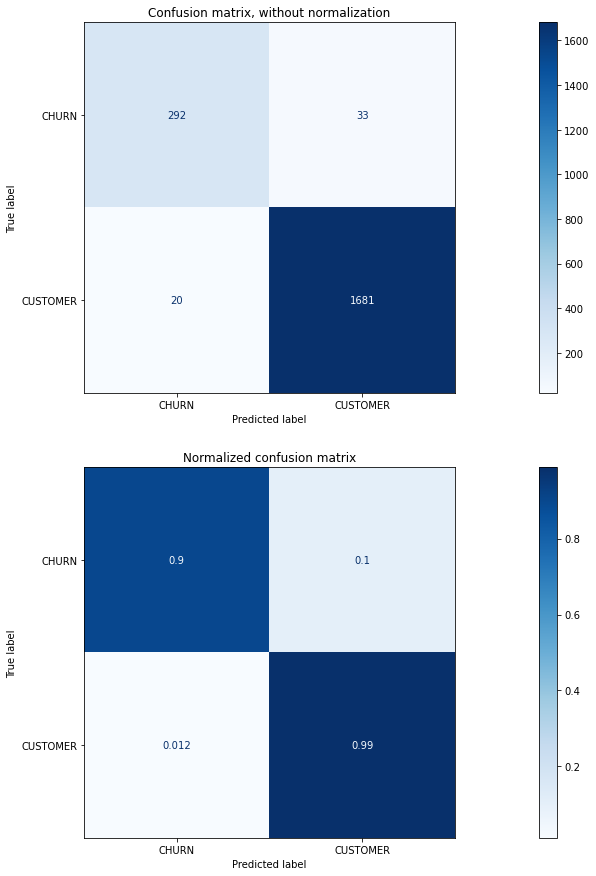

In [61]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
fig, ax =plt.subplots(2,1,figsize=(30,15))

for i in range(2):
    plot_confusion_matrix(best_gradient_cm,X_test, y_test,
                          display_labels=["CHURN", "CUSTOMER"],
                          cmap=plt.cm.Blues,
                          normalize=titles_options[i][1], ax = ax[i])
    
    ax[i].set_title(titles_options[i][0])
    

    print(titles_options[i])

plt.show()

### Misclassified Values

For ending the project, I would like to compare the amount of misclassified values from the `y_pred_gradient` compared with the correct output that might had.

First, let's compare the results from `y_pred_gradient` to `y_test` and, if they don't match, will append their index to an empty list for further exploration on the DF.

In [73]:
y_test_copy = np.asarray(y_test)

misclassified = []

for i in range(len(y_test_copy)):
    if y_test_copy[i] != y_pred_gradient[i]:
        misclassified.append(i)

In [74]:
# Copy of the original DF
bank_misclassified = bank.copy()

# Filtering only for the index misclassified
bank_misclassified = bank_misclassified.iloc[misclassified, :]

# Creating a new column with the wrong classification the model gave to that index
bank_misclassified.loc[:, "Classified_As"] = np.where(bank_misclassified["x1_Existing Customer"] == 0, 1, 0)

In [100]:
correct_classified = []

for i in range(len(y_test_copy)):
    if y_test_copy[i] == y_pred_gradient[i]:
        correct_classified.append(i)

In [101]:
# Copy of the original DF
bank_correct_classified = bank.copy()

# Filtering only for the index misclassified
bank_correct_classified = bank_correct_classified.iloc[correct_classified, :]

Let's see how many values were misclassified per each category:

In [79]:
bank_misclassified.Classified_As.value_counts()

0    47
1     5
Name: Classified_As, dtype: int64

Looking into that, we can see that more than 90% of the misclassifications are due to setting them as **churned customer**. Let's compare those misclassified customers with correct churned customers and try to find out why the model put them on the wrong batch.

For that case, although all columns are numerical, we will try to focus with the original numerical columns, not the encoded ones.

#### Wrong *Churned*

In [102]:
# Wrong Churned Anallysis
wrong_churned = bank_misclassified[bank_misclassified.Classified_As != 1]

In [103]:
# Churned when customer
wrong_churned = wrong_churned.iloc[:, :13].describe()
wrong_churned = wrong_churned.loc["mean"]

In [104]:
# Correct churned
bank_correct_classified = bank_correct_classified[bank_correct_classified["x1_Existing Customer"] == 0].iloc[:, :13].describe()
bank_correct_classified = bank_correct_classified.loc["mean"]

In [130]:
# Creating DF from variables
df = pd.concat([wrong_churned, bank_correct_classified], axis=1)

# Renaming columns
df.columns=["Mean_Incorrect_Churned", "Mean_Correct_Churned"]

# Unstacking them
df = df.unstack().reset_index()

# Renaming the new df with the proper column names
df.columns=["Classification", "Variable", "Value"]

df

,Classification,Variable,Value
0,Mean_Incorrect_Churned,Customer_Age,46.638298
1,Mean_Incorrect_Churned,Dependent_count,2.276596
2,Mean_Incorrect_Churned,Months_on_book,35.510638
3,Mean_Incorrect_Churned,Total_Relationship_Count,4.595745
4,Mean_Incorrect_Churned,Months_Inactive_12_mon,2.234043
5,Mean_Incorrect_Churned,Contacts_Count_12_mon,2.234043
6,Mean_Incorrect_Churned,Credit_Limit,7965.765957
7,Mean_Incorrect_Churned,Total_Revolving_Bal,1231.872340
8,Mean_Incorrect_Churned,Total_Amt_Chng_Q4_Q1,0.859064
9,Mean_Incorrect_Churned,Total_Trans_Amt,1700.808511


In [139]:
# Creating different DF for passing it to Seaborn
df_months_bank = df[df["Variable"] == "Months_on_book"]

df_transactions_change = df[df["Variable"] == "Total_Ct_Chng_Q4_Q1"]

df_card_utilization = df[df["Variable"] == "Avg_Utilization_Ratio"]

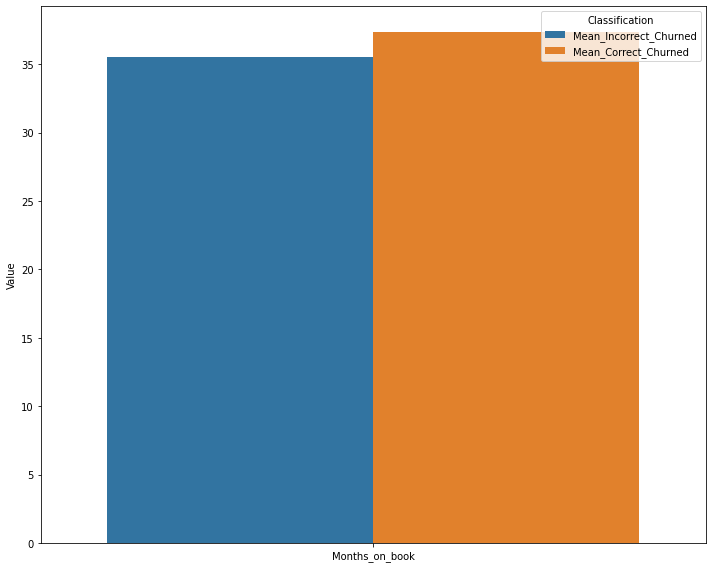

In [135]:
fig, ax = plt.subplots(figsize=(10,8))

sns.barplot(data=df_months_bank, x="Variable", y="Value", hue="Classification")

plt.xlabel("", fontsize=12)

plt.tight_layout()
plt.savefig("../images/months_bank_churn.png")
plt.show()

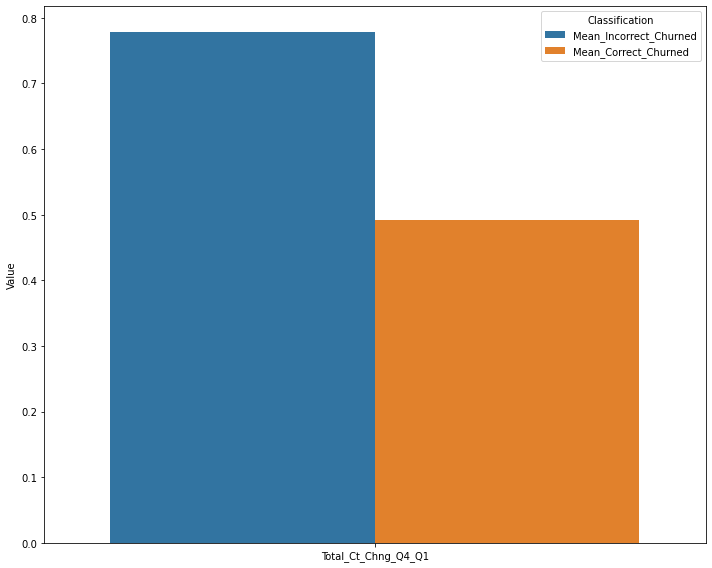

In [137]:
fig, ax = plt.subplots(figsize=(10,8))

sns.barplot(data=df_transactions_change, x="Variable", y="Value", hue="Classification")

plt.xlabel("", fontsize=12)

plt.tight_layout()
plt.savefig("../images/transactions_difference_churn.png")
plt.show()

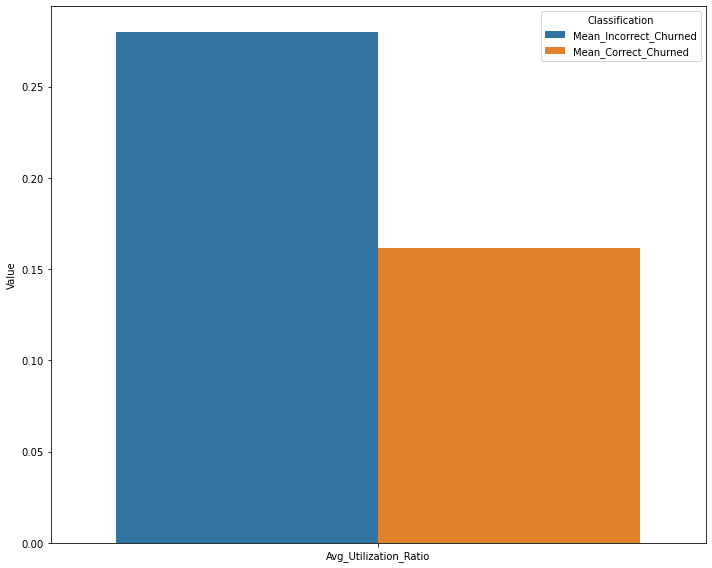

In [140]:
fig, ax = plt.subplots(figsize=(10,8))

sns.barplot(data=df_card_utilization, x="Variable", y="Value", hue="Classification")

plt.xlabel("", fontsize=12)

plt.tight_layout()
plt.savefig("../images/card_utilization_rate_churn.png")
plt.show()

#### Wrong *Customer*

In [297]:
# Wrong Customer Analysis
wrong_customer = bank_misclassified[bank_misclassified.Classified_As != 0]
correct_customer = bank.copy()

In [298]:
# Customer when churned
wrong_customer = wrong_customer.iloc[:, :13].describe()
wrong_customer = wrong_customer.loc["mean"]

In [300]:
# Correct customers
correct_customer = correct_customer[correct_customer["x1_Existing Customer"] == 1].iloc[:, :13].describe()
correct_customer = correct_customer.loc["mean"]

In [373]:
values_customer = []

for i in zip(wrong_customer, correct_customer):
    values_customer.append(i)

In [374]:
values_customer = [list(element) for element in values_customer]

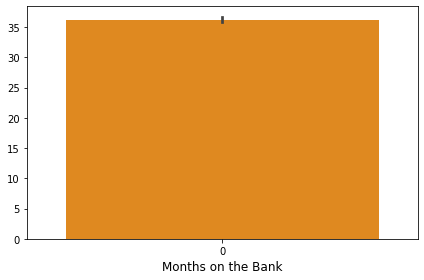

In [406]:
sns.barplot(data=values_customer[2], color="darkorange")

plt.xlabel("Months on the Bank", fontsize=12)

plt.tight_layout()
plt.savefig("../images/months_bank_customer.png")
plt.show()

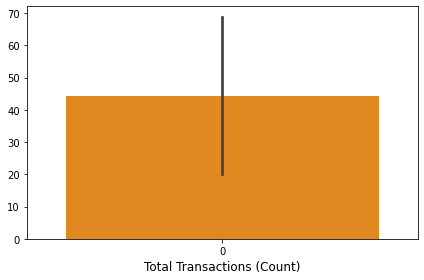

In [408]:
sns.barplot(data=values_customer[-3], color="darkorange")

plt.xlabel("Total Transactions (Count)", fontsize=12)

plt.tight_layout()
plt.savefig("../images/transactions_count_customer.png")
plt.show()

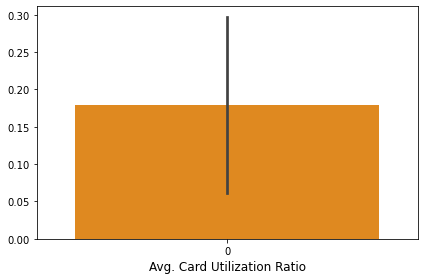

In [410]:
sns.barplot(data=values_customer[-1], color="darkorange")

plt.xlabel("Avg. Card Utilization Ratio", fontsize=12)

plt.tight_layout()
plt.savefig("../images/card_utilization_rate_customer.png")
plt.show()